## ML solution to the IVP of pendulum

#### Required packages

See the ODE_intro notebook for the packages.

### System 1: Simple pendulum

The simple pendulum setting is described in:

 * [Wikipedia](https://en.wikipedia.org/wiki/Pendulum_(mechanics))
 * [Blog](https://akhatib.com/simple-state-space-model-of-a-pendulum/)

#### Define a number of useful functions

Pendulum ODE function

In [2]:
def f(t_, x_):
    g = -9.81
    l = 2.0
    dotx = np.empty(x_.shape)
    dotx[0] = x_[1] # angular velocity
    dotx[1] = -g/l*np.sin(x_[0]) # angular acceleration
    return dotx

Plot function 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

def pendulum_plot(t_,y_):
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    plt.plot(t_, y_[0,:]*180/np.pi)
    plt.plot(t_, y_[0,:]*180/np.pi,'k.')
    plt.xlabel('time t [s]')
    plt.ylabel(r'$\theta$ [deg]')
    plt.subplot(122)
    plt.plot(t_, y_[1,:])
    plt.plot(t_, y_[1,:],'k.')
    plt.xlabel('time t [s]')
    plt.ylabel(r'$\dot\theta$ [rad/s]')
    #plt.tight_layout
    #plt.savefig('ode_pendulum_euler_100pts.png')
    plt.show()

def pendulum_comparison_plot(t_gt_,y_gt_, t_, y_):
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    plt.plot(t_gt_, y_gt_[0,:]*180/np.pi,'k-')
    plt.plot(t_, y_[0,:]*180/np.pi,'r--')
    plt.xlabel('time t [s]')
    plt.ylabel(r'$\theta$ [deg]')
    plt.subplot(122)
    plt.plot(t_gt_, y_gt_[1,:],'k-')
    plt.plot(t_, y_[1,:],'r--')
    plt.xlabel('time t [s]')
    plt.ylabel(r'$\dot\theta$ [rad/s]')
    plt.legend(['GT', 'Pred'])
    #plt.tight_layout
    #plt.savefig('ode_pendulum_euler_100pts.png')
    plt.show()

Trajectory generation - make sure the angle is pointing downwards so that sinusoida nonlinearities do not occur

In [4]:
def gen_trajectory(t_0_, t_n_, Delta_t_):

    # starting point is random (point downwards, though) and velocity zero
    y0 = [np.random.uniform(np.pi-np.pi/2, np.pi+np.pi/2), 0]

    t_eval = np.arange(t_0_, t_n_, Delta_t_)

    sol = solve_ivp(f, [t_0_, t_n_], y0, method = 'RK45', t_eval=t_eval)
    return sol

Trajectories of variable lenght to simulate the real world case better

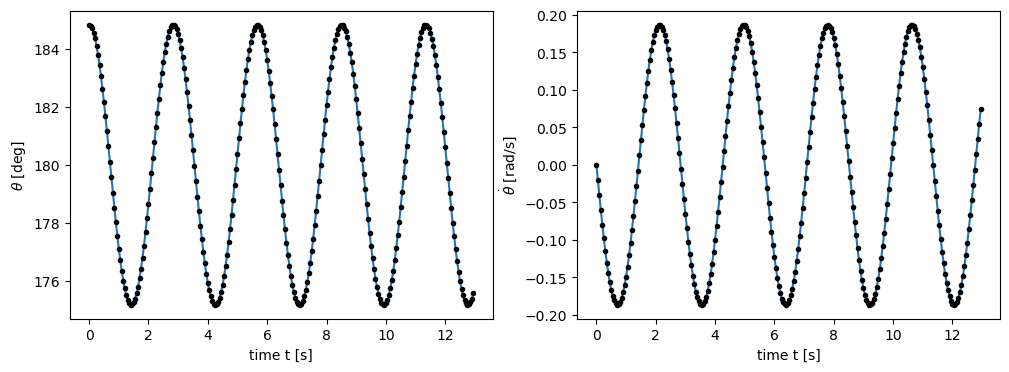

In [5]:
sol = gen_trajectory(0,np.random.uniform(10,15), 0.05)
pendulum_plot(sol.t, sol.y)

#### Finally, generate training and test data sets

In [6]:
N_tr = 13
N_te = 11

Y_tr = []
T_tr = []
Y_te = []
T_te = []

tot_samples_tr = 0
for t in range(N_tr):
    sol = gen_trajectory(0,np.random.uniform(10,15), 0.05)
    tot_samples_tr += sol.y.shape[1]
    Y_tr.append(sol.y)
    T_tr.append(sol.t)

tot_samples_te = 0
for t in range(N_te):
    sol = gen_trajectory(0,np.random.uniform(10,15), 0.05)
    tot_samples_te += sol.y.shape[1]
    Y_te.append(sol.y)
    T_te.append(sol.t)

print(f'Generated the total of {tot_samples_tr} training and {tot_samples_te} test samples')

Generated the total of 3251 training and 2682 test samples


### Neural regression

Basic neural network structure (two-layer MLP)

In [7]:
import torch

class BasicMLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super().__init__()

        self.dense1 = torch.nn.Linear(input_dim, hidden_size)
        self.dense2 = torch.nn.Linear(hidden_size, hidden_size)
        self.output = torch.nn.Linear(hidden_size, output_dim)

    def forward(self, x):

        x = self.dense1(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.dense2(x)
        x = torch.nn.functional.sigmoid(x)
        y_pred = self.output(x)

        return y_pred

#### MLP

Construct MLP

In [25]:
# Input [t,theta_0, dottheta_0] Output: [theta, dottheta]
model_mlp = BasicMLP(3,16,2)

print(model_mlp)
print(f'The model has {sum(p.numel() for p in model_mlp.parameters())} parameters ({sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)} trainable)')
print(f'Manual counting: {(3+1)*16+(16+1)*(16)+(16+1)*2}')

BasicMLP(
  (dense1): Linear(in_features=3, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)
The model has 370 parameters (370 trainable)
Manual counting: 370


Training loop

In [28]:
import torch.optim.lr_scheduler as lr_scheduler

num_of_epochs = 8000
loss_mse = torch.nn.MSELoss()
optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=0.1)
scheduler = lr_scheduler.LinearLR(optimizer_mlp, start_factor=0.1, end_factor=0.000001, total_iters=num_of_epochs-10)
model_mlp.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    for y,t in zip(Y_tr,T_tr):
        y = torch.from_numpy(y).float().t() # shape N,2
        t = torch.from_numpy(t).float()
        t = t.view(len(t),1) # shape N,1       
        
        y0 = y[0,:]
        y0_vec = y0.repeat(t.shape[0],1)
        X = torch.cat((t,y0_vec),1)
        optimizer_mlp.zero_grad()
        y_pred = model_mlp(X)
        loss = loss_mse(y_pred,y)
        loss.backward()
        optimizer_mlp.step()
        running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer_mlp.param_groups[0]["lr"]})')

   Epoch 0 training loss 44.77880930900574 (lr=0.009998748448060077)
   Epoch 100 training loss 12.853876411914825 (lr=0.009873593254067572)
   Epoch 200 training loss 10.047384202480316 (lr=0.009748438060075068)
   Epoch 300 training loss 9.315845787525177 (lr=0.009623282866082564)
   Epoch 400 training loss 9.016040027141571 (lr=0.00949812767209006)
   Epoch 500 training loss 8.651450604200363 (lr=0.009372972478097555)
   Epoch 600 training loss 7.20628659427166 (lr=0.00924781728410505)
   Epoch 700 training loss 6.568191930651665 (lr=0.009122662090112546)
   Epoch 800 training loss 6.204479783773422 (lr=0.008997506896120042)
   Epoch 900 training loss 5.898653216660023 (lr=0.008872351702127537)
   Epoch 1000 training loss 5.7632332518696785 (lr=0.008747196508135033)
   Epoch 1100 training loss 5.540364660322666 (lr=0.008622041314142528)
   Epoch 1200 training loss 5.413237176835537 (lr=0.008496886120150024)
   Epoch 1300 training loss 5.295277841389179 (lr=0.00837173092615752)
   Ep

#### MLP Evaluation

Training set performance

Average MSE over 13 trajectories is 0.6779982447624207 degrees
Average MAE over 13 trajectories is 7.389548301696777 degrees
Training trajectory and prediction number 4


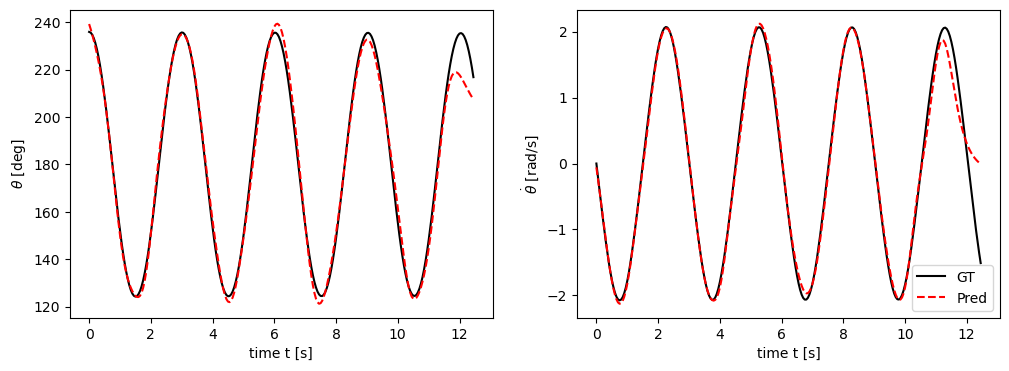

In [35]:
model_mlp.eval()
print_ind = np.random.randint(0,N_tr)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_tr,T_tr):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape N,1       
        
    y0 = y[0,:]
    y0_vec = y0.repeat(t.shape[0],1)
    X = torch.cat((t,y0_vec),1)

    y_pred = model_mlp(X).detach()
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t 
avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

Test set performance

Average MSE over 11 trajectories is 1.4025437831878662 degrees
Average MAE over 11 trajectories is 16.546743392944336 degrees
Test trajectory and prediction number 7


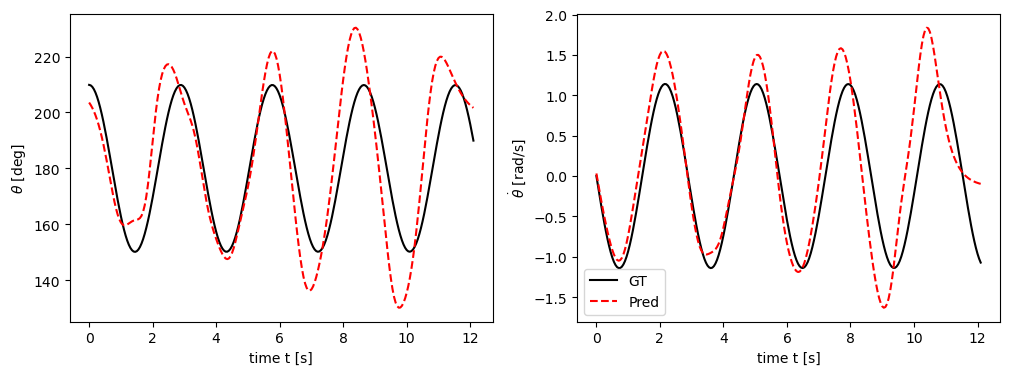

In [36]:
model_mlp.eval()
print_ind = np.random.randint(0,N_te)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_te,T_te):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape N,1       
        
    y0 = y[0,:]
    y0_vec = y0.repeat(t.shape[0],1)
    X = torch.cat((t,y0_vec),1)

    y_pred = model_mlp(X).detach()
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t 
avg_theta_mse = sum(theta_mse)/N_te
avg_theta_mae = sum(theta_mae)/N_te
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Test trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

#### MLP-Seq

In [8]:
# Input [theta_n, dottheta_n] Output: [theta_n+1, dottheta_n+1]
model_mlpseq = BasicMLP(2,16,2)

print(model_mlpseq)
print(f'The model has {sum(p.numel() for p in model_mlpseq.parameters())} parameters ({sum(p.numel() for p in model_mlpseq.parameters() if p.requires_grad)} trainable)')

BasicMLP(
  (dense1): Linear(in_features=2, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)
The model has 354 parameters (354 trainable)


Training

In [10]:
import torch.optim.lr_scheduler as lr_scheduler

num_of_epochs = 8000
loss_mseseq = torch.nn.MSELoss()
optimizer_mlpseq = torch.optim.Adam(model_mlpseq.parameters(), lr=0.1)
scheduler = lr_scheduler.LinearLR(optimizer_mlpseq, start_factor=0.1, end_factor=0.000001, total_iters=num_of_epochs-10)
model_mlpseq.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    for y,t in zip(Y_tr,T_tr):
        y = torch.from_numpy(y).float().t() # shape N,2
        t = torch.from_numpy(t).float()
        t = t.view(len(t),1) # shape N,1       

        y_in = y[:-1,:]
        y_out = y[1:,:]
        optimizer_mlpseq.zero_grad()
        y_pred = model_mlpseq(y_in)
        loss = loss_mseseq(y_out,y_pred)
        loss.backward()
        optimizer_mlpseq.step()
        running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer_mlpseq.param_groups[0]["lr"]})')

   Epoch 0 training loss 35.104131519794464 (lr=0.009998748448060077)
   Epoch 100 training loss 0.01974487073312048 (lr=0.009873593254067572)
   Epoch 200 training loss 0.013179284478610498 (lr=0.009748438060075068)
   Epoch 300 training loss 0.01071539470103744 (lr=0.009623282866082564)
   Epoch 400 training loss 0.007430358848978358 (lr=0.00949812767209006)
   Epoch 500 training loss 0.009221578478900483 (lr=0.009372972478097555)
   Epoch 600 training loss 0.015229428076054319 (lr=0.00924781728410505)
   Epoch 700 training loss 0.006761982573152636 (lr=0.009122662090112546)
   Epoch 800 training loss 0.0070142458516784245 (lr=0.008997506896120042)
   Epoch 900 training loss 0.007918281591628329 (lr=0.008872351702127537)
   Epoch 1000 training loss 0.004339378409895289 (lr=0.008747196508135033)
   Epoch 1100 training loss 0.0055553668171342 (lr=0.008622041314142528)
   Epoch 1200 training loss 0.008236800867052807 (lr=0.008496886120150024)
   Epoch 1300 training loss 0.01173107684007

#### MLP-Seq evaluation

Training set performance

Average MSE over 13 trajectories is 0.1600475311279297 degrees
Average MAE over 13 trajectories is 1.8963903188705444 degrees
Training trajectory and prediction number 4


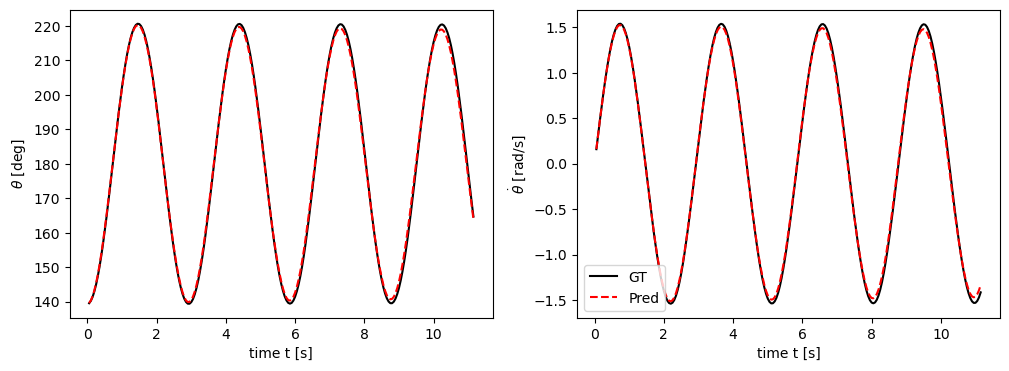

In [11]:
model_mlpseq.eval()
print_ind = np.random.randint(0,N_tr)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_tr,T_tr):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       

    y_in = y[:-1,:]
    y_out = y[1:,:]
    t_out = t[1:]
    y_pred = torch.empty(y_out.shape)
    y_pred[0,:] = model_mlpseq(y_in[0,:].float())

    for te_ind in range(1,y_out.shape[0]):
        y_pred[te_ind,:] = model_mlpseq(y_pred[te_ind-1,:])
    y_pred = y_pred.detach()
    y = y_out # First element is not counted as it is not estimated
    t = t_out
    
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t

avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

Test set performance

Average MSE over 11 trajectories is 0.32895803451538086 degrees
Average MAE over 11 trajectories is 3.856165885925293 degrees
Test trajectory and prediction number 5


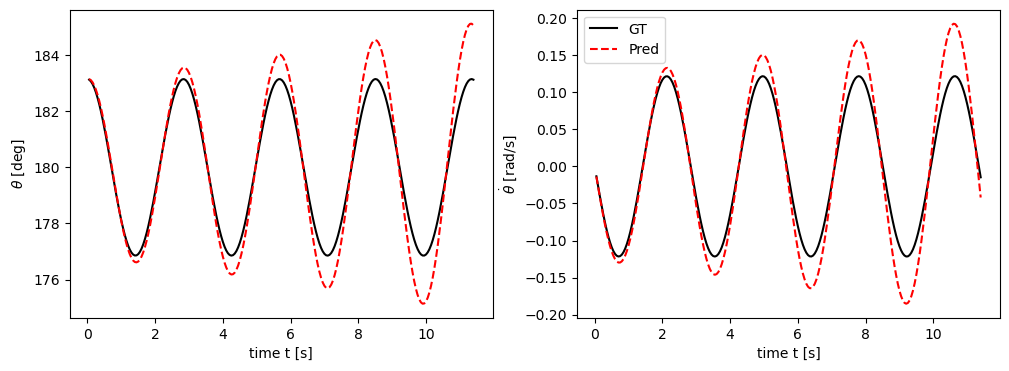

In [13]:
model_mlpseq.eval()
print_ind = np.random.randint(0,N_te)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_te,T_te):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       

    y_in = y[:-1,:]
    y_out = y[1:,:]
    t_out = t[1:]
    y_pred = torch.empty(y_out.shape)
    y_pred[0,:] = model_mlpseq(y_in[0,:].float())

    for te_ind in range(1,y_out.shape[0]):
        y_pred[te_ind,:] = model_mlpseq(y_pred[te_ind-1,:])
    y_pred = y_pred.detach()
    y = y_out # First element is not counted as it is not estimated
    t = t_out
    
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t

avg_theta_mse = sum(theta_mse)/N_te
avg_theta_mae = sum(theta_mae)/N_te
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Test trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

### Physics-informed neural network 

Construct the PINN network which is actually similar to the MLP model

In [8]:
model_pinn = BasicMLP(3,16,2)

print(model_pinn)
print(f'The model has {sum(p.numel() for p in model_pinn.parameters())} parameters ({sum(p.numel() for p in model_pinn.parameters() if p.requires_grad)} trainable)')

BasicMLP(
  (dense1): Linear(in_features=3, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)
The model has 370 parameters (370 trainable)


Train the model 

In [10]:
import time
import torch.optim.lr_scheduler as lr_scheduler

num_of_epochs = 8000
pinn_g = -9.81
pinn_l = 2.0
loss_mse_weight = 0.9
loss_mse = torch.nn.MSELoss()
loss_pinn = torch.nn.MSELoss()
optimizer_pinn = torch.optim.Adam(model_pinn.parameters(), lr=0.1)
scheduler = lr_scheduler.LinearLR(optimizer_pinn, start_factor=0.1, end_factor=0.000001, total_iters=num_of_epochs-10)
model_pinn.train()
start = time.time()
for n in range(num_of_epochs):
    running_loss = 0.0
    running_loss_mse = 0.0
    for y,t in zip(Y_tr,T_tr):
        y = torch.from_numpy(y).float().t() # shape N,2
        t = torch.from_numpy(t).float()
        t = t.view(len(t),1) # shape N,1       
        ddot_theta = -pinn_g/pinn_l*torch.sin(y[:,0])
        
        y0 = y[0,:]
        y0_vec = y0.repeat(t.shape[0],1)
        X = torch.cat((t,y0_vec),1)
        optimizer_pinn.zero_grad()
        y_pred = model_pinn(X)
        loss_1 = loss_mse(y_pred,y)
        loss_2 = loss_pinn(-pinn_g/pinn_l*torch.sin(y_pred[:,0]),ddot_theta)
        loss = loss_mse_weight*loss_1+(1-loss_mse_weight)*loss_2
        loss.backward()
        optimizer_pinn.step()
        running_loss += loss.item()
        running_loss_mse += loss_1.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} [MSE loss {running_loss_mse}] (lr={optimizer_pinn.param_groups[0]["lr"]})')
end = time.time()

print(f'Training took {end - start} seconds')

   Epoch 0 training loss 69.20991158485413 [MSE loss 54.99885702133179] (lr=0.009998748448060077)
   Epoch 100 training loss 14.791181296110153 [MSE loss 9.62770164012909] (lr=0.009873593254067572)
   Epoch 200 training loss 12.414424106478691 [MSE loss 8.239021107554436] (lr=0.009748438060075068)
   Epoch 300 training loss 11.390198156237602 [MSE loss 7.604371786117554] (lr=0.009623282866082564)
   Epoch 400 training loss 10.805078342556953 [MSE loss 7.2334087789058685] (lr=0.00949812767209006)
   Epoch 500 training loss 10.372543752193451 [MSE loss 6.940789699554443] (lr=0.009372972478097555)
   Epoch 600 training loss 9.964868739247322 [MSE loss 6.606003537774086] (lr=0.00924781728410505)
   Epoch 700 training loss 9.542470291256905 [MSE loss 6.183418191969395] (lr=0.009122662090112546)
   Epoch 800 training loss 9.095723077654839 [MSE loss 5.713644444942474] (lr=0.008997506896120042)
   Epoch 900 training loss 8.666110813617706 [MSE loss 5.345402792096138] (lr=0.008872351702127537)

#### PINN evaluation

Training performance

Average MSE over 13 trajectories is 0.6087016463279724 degrees
Average MAE over 13 trajectories is 6.953091144561768 degrees
Training trajectory and prediction number 6


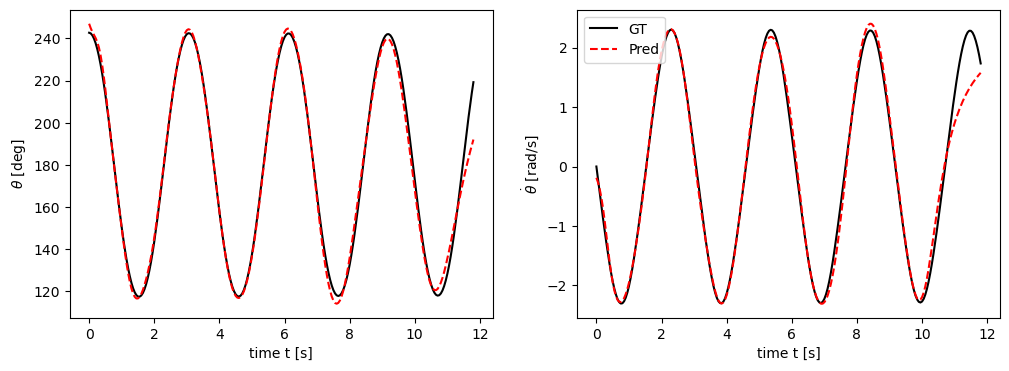

In [12]:
model_pinn.eval()
print_ind = np.random.randint(0,N_tr)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_tr,T_tr):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       
        
    y0 = y[0,:]
    y0_vec = y0.repeat(t.shape[0],1)
    X = torch.cat((t,y0_vec),1)

    y_pred = model_pinn(X).detach()
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t 
avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

Test performance

Average MSE over 11 trajectories is 1.1724029779434204 degrees
Average MAE over 11 trajectories is 14.080713272094727 degrees
Test trajectory and prediction number 1


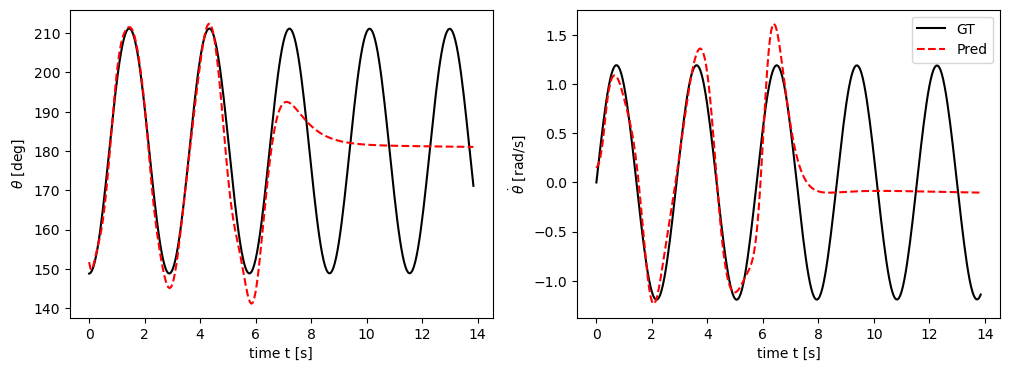

In [13]:
model_pinn.eval()
print_ind = np.random.randint(0,N_te)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_te,T_te):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       
        
    y0 = y[0,:]
    y0_vec = y0.repeat(t.shape[0],1)
    X = torch.cat((t,y0_vec),1)

    y_pred = model_pinn(X).detach()
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t 
avg_theta_mse = sum(theta_mse)/N_te
avg_theta_mae = sum(theta_mae)/N_te
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Test trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

### PDE-Net

In [119]:
import torch

class PDENet(torch.nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super().__init__()

        self.dense1 = torch.nn.Linear(input_dim, hidden_size)
        self.dense2 = torch.nn.Linear(hidden_size, hidden_size)
        self.output = torch.nn.Linear(hidden_size, output_dim)

    def forward(self, x, stepnum):

        for i in range(stepnum):
            ufd = self.dense1(x) # D_00 conv x
            ufd = torch.nn.functional.sigmoid(ufd) 
            ufd = self.dense2(ufd) # D_00 conv x
            ufd = self.output(ufd) 
            #ufd = torch.nn.functional.sigmoid(ufd) 
            #x = torch.nn.functional.sigmoid(x)
            x = x+ufd
            #x = self.dense2(x)
            #x = torch.nn.functional.sigmoid(x)
        y_pred = x

        return y_pred

Construct network

In [120]:
model_pdenet = PDENet(2,16,2)

print(model_pdenet)
print(f'The model has {sum(p.numel() for p in model_pdenet.parameters())} parameters ({sum(p.numel() for p in model_pdenet.parameters() if p.requires_grad)} trainable)')

PDENet(
  (dense1): Linear(in_features=2, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)
The model has 354 parameters (354 trainable)


Train

In [121]:
stepnum = 10
num_of_epochs = 8000
loss_pdenet = torch.nn.MSELoss()
optimizer_pdenet = torch.optim.Adam(model_pdenet.parameters(), lr=0.01)
scheduler = lr_scheduler.LinearLR(optimizer_pdenet, start_factor=0.1, end_factor=0.0000001, total_iters=num_of_epochs-10)
model_pdenet.train()
start = time.time()
for n in range(num_of_epochs):
    running_loss = 0.0
    for y,t in zip(Y_tr,T_tr):
        y = torch.from_numpy(y).float().t() # shape N,2
        t = torch.from_numpy(t).float()
        t = t.view(len(t),1) # shape N,1       

        y_in = y[:-1,:]
        y_out = y[1:,:]
        optimizer_pdenet.zero_grad()
        y_pred = model_pdenet(y_in,stepnum)
        loss = loss_pdenet(y_out,y_pred)
        loss.backward()
        optimizer_pdenet.step()
        running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer_pdenet.param_groups[0]["lr"]})')
end = time.time()

print(f'Training took {end - start} seconds')

   Epoch 0 training loss 13.610232062637806 (lr=0.0009998748436795995)
   Epoch 100 training loss 0.008877470856532454 (lr=0.0009873592116395452)
   Epoch 200 training loss 0.005603210869594477 (lr=0.0009748435795994916)
   Epoch 300 training loss 0.0035321118994033895 (lr=0.0009623279475594417)
   Epoch 400 training loss 0.0037166245601838455 (lr=0.0009498123155193918)
   Epoch 500 training loss 0.002855720456864219 (lr=0.0009372966834793417)
   Epoch 600 training loss 0.002143030629667919 (lr=0.000924781051439292)
   Epoch 700 training loss 0.001876980095403269 (lr=0.000912265419399242)
   Epoch 800 training loss 0.00187487081711879 (lr=0.0008997497873591922)
   Epoch 900 training loss 0.001777253215550445 (lr=0.0008872341553191424)
   Epoch 1000 training loss 0.0016267868195427582 (lr=0.0008747185232790926)
   Epoch 1100 training loss 0.001489864349423442 (lr=0.0008622028912390434)
   Epoch 1200 training loss 0.0013774720919172978 (lr=0.0008496872591989944)
   Epoch 1300 training lo

#### PDE-Net evaluation

Training performance

Average MSE over 13 trajectories is 0.09514761716127396 degrees
Average MAE over 13 trajectories is 1.1977012157440186 degrees
Training trajectory and prediction number 4


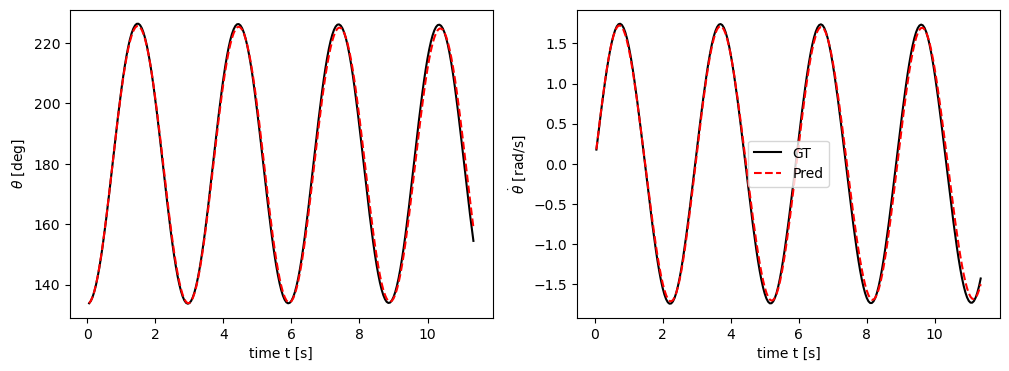

In [122]:
model_pdenet.eval()
print_ind = np.random.randint(0,N_tr)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_tr,T_tr):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       

    y_in = y[:-1,:]
    y_out = y[1:,:]
    t_out = t[1:]
    y_pred = torch.empty(y_out.shape)
    y_pred[0,:] = model_pdenet(y_in[0,:].float(),stepnum)

    for te_ind in range(1,y_out.shape[0]):
        y_pred[te_ind,:] = model_pdenet(y_pred[te_ind-1,:], stepnum)
    y_pred = y_pred.detach()
    y = y_out # First element is not counted as it is not estimated
    t = t_out
    
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t

avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

Test set performance

Average MSE over 11 trajectories is 0.10467594861984253 degrees
Average MAE over 11 trajectories is 1.3242253065109253 degrees
Test trajectory and prediction number 4


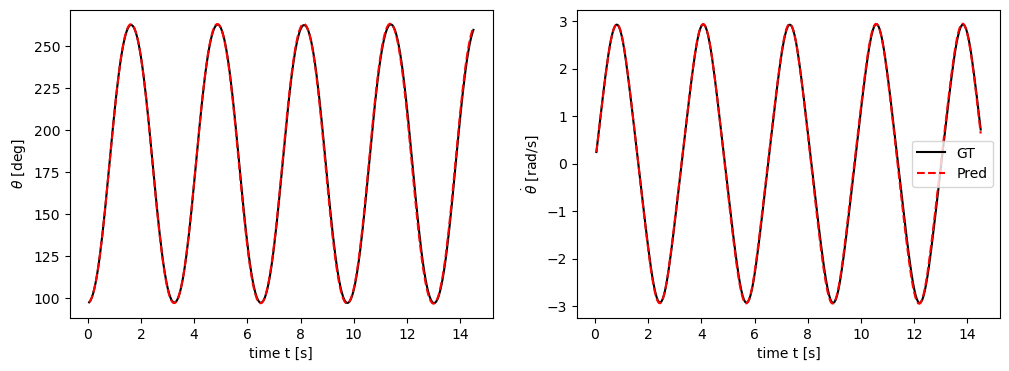

In [123]:
model_pdenet.eval()
print_ind = np.random.randint(0,N_te)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_te,T_te):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       

    y_in = y[:-1,:]
    y_out = y[1:,:]
    t_out = t[1:]
    y_pred = torch.empty(y_out.shape)
    y_pred[0,:] = model_pdenet(y_in[0,:].float(),stepnum)

    for te_ind in range(1,y_out.shape[0]):
        y_pred[te_ind,:] = model_pdenet(y_pred[te_ind-1,:], stepnum)
    y_pred = y_pred.detach()
    y = y_out # First element is not counted as it is not estimated
    t = t_out
    
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t

avg_theta_mse = sum(theta_mse)/N_te
avg_theta_mae = sum(theta_mae)/N_te
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Test trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

### LSTM network

Define the structure

In [14]:
class myLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = torch.nn.LSTM(input_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, output_size)


    def forward(self, X, h_t=None, c_t=None):
        if h_t is None:
          outputs, (h_t, c_t) = self.lstm(X)
          outputs = self.linear(outputs)
        else:
          outputs, (h_t, c_t) = self.lstm(X,(h_t,c_t))
          outputs = self.linear(outputs)

        return outputs, h_t, c_t

Construct the LSTM model

In [33]:
model_lstm = myLSTM(2,8,2)

print(model_lstm)
print(f'The model has {sum(p.numel() for p in model_lstm.parameters())} parameters ({sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)} trainable)')

myLSTM(
  (lstm): LSTM(2, 8)
  (linear): Linear(in_features=8, out_features=2, bias=True)
)
The model has 402 parameters (402 trainable)


Train the network

In [34]:
import time

num_of_epochs = 4000
loss_lstm = torch.nn.MSELoss()
#loss_lstm = torch.nn.L1Loss()
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.1)
scheduler = lr_scheduler.LinearLR(optimizer_lstm, start_factor=0.1, end_factor=0.0001, total_iters=num_of_epochs-100)
model_lstm.train()
start = time.time()
for n in range(num_of_epochs):
    running_loss = 0.0
    for y,t in zip(Y_tr,T_tr):
        y = torch.from_numpy(y).float().t() # shape N,2
        t = torch.from_numpy(t).float()
        t = t.view(len(t),1) # shape N,1       

        y_in = y[:-1,:]
        y_out = y[1:,:]
        optimizer_lstm.zero_grad()
        y_pred, _, _ = model_lstm(y_in)
        loss = loss_lstm(y_out,y_pred)
        loss.backward()
        optimizer_lstm.step()
        running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer_lstm.param_groups[0]["lr"]})')
end = time.time()

print(f'Training took {end - start} seconds')

   Epoch 0 training loss 59.58199739456177 (lr=0.009997438461538463)
   Epoch 100 training loss 0.016822549048811197 (lr=0.009741284615384614)
   Epoch 200 training loss 0.010203162717516534 (lr=0.009485130769230753)
   Epoch 300 training loss 0.009270009133615531 (lr=0.009228976923076905)
   Epoch 400 training loss 0.00606741617048101 (lr=0.008972823076923046)
   Epoch 500 training loss 0.008606437790149357 (lr=0.008716669230769199)
   Epoch 600 training loss 0.0022183396667969646 (lr=0.008460515384615336)
   Epoch 700 training loss 0.0014187502833920007 (lr=0.00820436153846148)
   Epoch 800 training loss 0.004644199307222152 (lr=0.007948207692307616)
   Epoch 900 training loss 0.011257785326961312 (lr=0.00769205384615377)
   Epoch 1000 training loss 0.0004273874847058323 (lr=0.007435899999999934)
   Epoch 1100 training loss 0.002519720550480997 (lr=0.0071797461538460885)
   Epoch 1200 training loss 0.003582027700758772 (lr=0.006923592307692249)
   Epoch 1300 training loss 0.001208791

#### Evaluate LSTM

Training data

Average MSE over 13 trajectories is 0.21834537386894226 degrees
Average MAE over 13 trajectories is 2.665733814239502 degrees
Training trajectory and prediction number 0


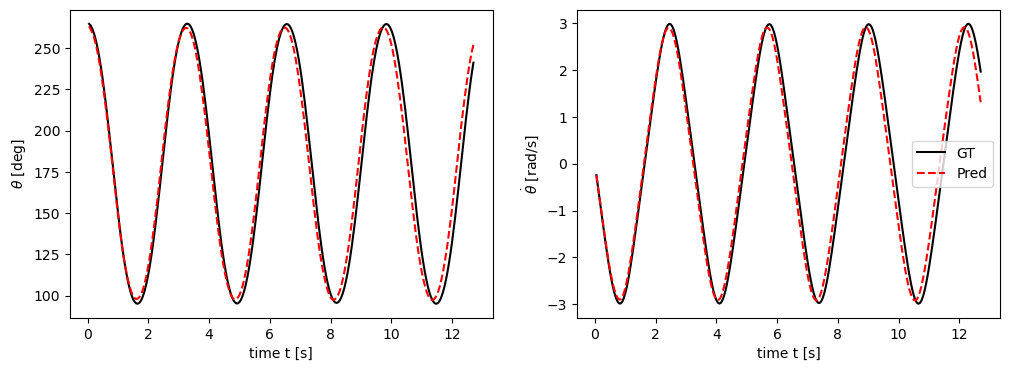

In [35]:
model_lstm.eval()
print_ind = np.random.randint(0,N_tr)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_tr,T_tr):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       

    y_in = y[:-1,:]
    y_out = y[1:,:]
    t_out = t[1:]
    y_pred = torch.empty(y_out.shape)
    y_pred[0,:], h_t, c_t = model_lstm(y_in[0,:].view(1,-1).float())

    for te_ind in range(1,y_out.shape[0]):
        y_pred[te_ind,:], h_t, c_t = model_lstm(y_pred[te_ind-1,:].view(1,-1), h_t, c_t)
    y_pred = y_pred.detach()
    y = y_out # First element is not counted as it is not estimated
    t = t_out
    
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t

avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

Test data performance

Average MSE over 11 trajectories is 0.3073166608810425 degrees
Average MAE over 11 trajectories is 3.749825954437256 degrees
Test trajectory and prediction number 8


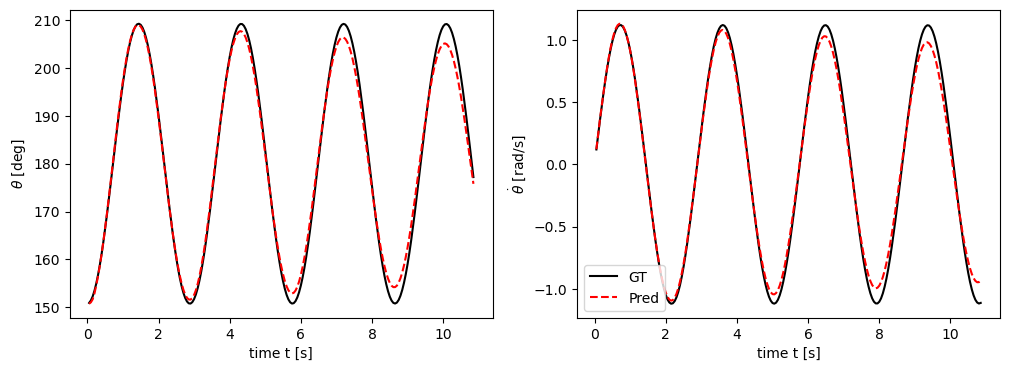

In [36]:
model_lstm.eval()
print_ind = np.random.randint(0,N_te)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_te,T_te):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       

    y_in = y[:-1,:]
    y_out = y[1:,:]
    t_out = t[1:]
    y_pred = torch.empty(y_out.shape)
    y_pred[0,:], h_t, c_t = model_lstm(y_in[0,:].view(1,-1).float())

    for te_ind in range(1,y_out.shape[0]):
        y_pred[te_ind,:], h_t, c_t = model_lstm(y_pred[te_ind-1,:].view(1,-1), h_t, c_t)
    y_pred = y_pred.detach()
    y = y_out # First element is not counted as it is not estimated
    t = t_out
    
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t

avg_theta_mse = sum(theta_mse)/N_te
avg_theta_mae = sum(theta_mae)/N_te
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Test trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

### Results

It looks like the MLPSeq baseline (Baseline 2) works well with the same setting as the previous MLP (Baseline 1). At the end the training MSE error is 0.000026 which is much lower than BL1, but the average training (1.17deg) and validation MAE (1.7deg) are only littler better. 

MLP with the PINN loss term seems to obtain MSE training error 0.029 and total error 0.031 and average MAE for training data 0.73deg and for validation data 1.25deg

Below are the test set average MAE numbers in degrees

| Test       |     MLP       |     MLP-Seq  |        PINN   | PDE-Net (1)   | PDE-Net (10)      | LSTM              | Transformer |
|:----------:|:-------------:|:------------:|:-------------:|:-------------:|:-----------------:|:-----------------:|:-----------------:|
|  Round 1   |  11.18        |      2.30    |       5.96    |      1.10     |                   |    3.75
|  Round 3   |  13.40        |      4.33    |       7.04    |      1.54     |
|  Round 4   |   9.58        |      3.65    |       7.00    |     13.51     |
|  Round 5   |  10.74        |      1.26    |       9.93    |      1.62     |  1.32
|   *Avg*    | 11.7$\pm$1.60 | 2.5$\pm$1.29 | 7.89$\pm$1.56 | 4.44$\pm$5.24 |

In [118]:
np.std([1.10,1.54,13.51,1.62])

5.238866170270051